Imports

In [4]:
import napari
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage import measure
from arcos4py.tools import track_events_image
from napari_timestamper import render_as_rgb, save_image_stack
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from scipy import ndimage

import numpy as np
from scipy import ndimage
from skimage.morphology import binary_opening, square
from matplotlib_scalebar.scalebar import ScaleBar

from napari_convpaint import conv_paint_utils
import numpy as np
import napari

# set plot parameters for publication quality
from matplotlib import rcParams
import nd2
plt.rcParams['svg.fonttype'] = 'none'
rcParams['font.family'] = 'Arial'


Some function defs

In [5]:
from typing import Tuple, Optional, Callable, Union, Literal
from scipy.optimize import curve_fit

ExpFuncType = Callable[[np.ndarray, float, float], np.ndarray]

# Function type for _bi_exp
BiExpFuncType = Callable[[np.ndarray, float, float, float, float], np.ndarray]

# Union type for both function types
FuncType = Union[ExpFuncType, BiExpFuncType]


def _exp(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a * np.exp(-b * x)


def _bi_exp(x: np.ndarray, a: float, b: float, c: float, d: float) -> np.ndarray:
    return (a * np.exp(-b * x)) + (c * np.exp(-d * x))


def _exponential_correct(
    images: np.ndarray,
    contrast_limits: Optional[Tuple[int, int]] = None,
    method: Literal["mono", "bi"] = "mono",
) -> np.ndarray:
    """Corrects photobleaching in a 3D or 4D image stack using an exponential curve.

    Adapted from:
    https://github.com/marx-alex/napari-bleach-correct/blob/main/src/napari_bleach_correct/modules/exponential.py.
    """
    dtype = images.dtype
    if contrast_limits is None:
        contrast_limits = (np.min(images), np.max(images))
    assert (
        3 <= len(images.shape) <= 4
    ), f"Expected 3d or 4d image stack, instead got {len(images.shape)} dimensions"

    avail_methods = ["mono", "bi"]
    func: FuncType
    if method == "mono":
        func = _exp
    elif method == "bi":
        func = _bi_exp
    else:
        raise NotImplementedError(
            f"method must be one of {avail_methods}, instead got {method}"
        )

    axes = tuple(range(len(images.shape)))
    I_mean = np.mean(images, axis=axes[1:])
    x_data = np.arange(images.shape[0])

    with np.errstate(over="ignore"):
        try:
            popt, _ = curve_fit(func, x_data, I_mean)
            f_ = np.vectorize(func)(x_data, *popt)
        except (ValueError, RuntimeError, Warning):
            f_ = np.ones(x_data.shape)

    residuals = I_mean - f_
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((I_mean - np.mean(I_mean)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R^2: {r_squared}")

    f = f_ / np.max(f_)
    if len(images.shape) == 3:
        f = f.reshape(-1, 1, 1)
    else:
        f = f.reshape(-1, 1, 1, 1)
    images = images / f

    images[images < contrast_limits[0]] = contrast_limits[0]
    images[images > contrast_limits[1]] = contrast_limits[1]
    return images.astype(dtype)

from skimage.measure import regionprops
import pandas as pd
import numpy as np

def labels_to_positions_df(label_stack, spacing=(1.0, 1.0, 1.0), time_axis=0):
    """
    Converts a label image stack into a positions DataFrame required for napari tracks.

    Args:
        label_stack (numpy.ndarray): 3D or 4D numpy array where each frame is a labeled image.
            Shape can be (T, Z, Y, X) or (T, Y, X) depending on whether it's 3D or 2D data.
        spacing (tuple): Physical spacing between pixels in each dimension (Z, Y, X).
        time_axis (int): The axis corresponding to time in the label_stack.

    Returns:
        positions_df (pd.DataFrame): DataFrame with columns:
            - 'cluster_id'
            - 'frame'
            - 'z' (if applicable)
            - 'y'
            - 'x'
            - Other region properties as needed
    """
    # Initialize an empty list to collect data
    data = []

    # Move the time axis to the first position
    label_stack = np.moveaxis(label_stack, time_axis, 0)

    # Determine if data is 2D or 3D
    is_3d = label_stack.ndim == 4  # (T, Z, Y, X)

    # Iterate over frames
    for t, frame_labels in enumerate(label_stack):
        if is_3d:
            # For 3D data, frame_labels shape is (Z, Y, X)
            regions = regionprops(frame_labels)
            for region in regions:
                centroid = region.centroid  # (z, y, x)
                cluster_id = region.label
                data.append({
                    'cluster_id': cluster_id,
                    'frame': t,
                    'z': centroid[0] * spacing[0],
                    'y': centroid[1] * spacing[1],
                    'x': centroid[2] * spacing[2],
                    # Add other properties if needed
                })
        else:
            # For 2D data, frame_labels shape is (Y, X)
            regions = regionprops(frame_labels)
            for region in regions:
                centroid = region.centroid  # (y, x)
                cluster_id = region.label
                data.append({
                    'cluster_id': cluster_id,
                    'frame': t,
                    'y': centroid[0] * spacing[1],
                    'x': centroid[1] * spacing[2],
                    # Add other properties if needed
                })

    # Create DataFrame
    positions_df = pd.DataFrame(data)

    # Reorder columns
    columns = ['cluster_id', 'frame']
    if is_3d:
        columns += ['z', 'y', 'x']
    else:
        columns += ['y', 'x']
    positions_df = positions_df[columns]

    return positions_df

def tracker_to_napari_tracks(
    tracker,
    positions_df=None,
    label_stack=None,
    spacing=(1.0, 1.0, 1.0),
    time_axis=0,
    position_cols=None
):
    """
    Generates data for napari tracks layer from a LineageTracker instance.

    Args:
        tracker (LineageTracker): An instance of LineageTracker.
        positions_df (pd.DataFrame, optional): DataFrame containing positional data with columns:
            - 'cluster_id'
            - 'frame' (or 'time')
            - position columns (e.g., 'x', 'y', 'z')
        label_stack (numpy.ndarray, optional): Label image stack with cluster IDs as labels.
            Provide either positions_df or label_stack.
        spacing (tuple): Physical spacing between pixels in each dimension (Z, Y, X).
            Used if label_stack is provided.
        time_axis (int): The axis corresponding to time in the label_stack.
            Used if label_stack is provided.
        position_cols (list, optional): List of column names for spatial coordinates.
            If None, defaults to ['z', 'y', 'x'] for 3D or ['y', 'x'] for 2D data.

    Returns:
        tuple: (data, properties, graph)
            - data: NumPy array of shape (N, D+2)
            - properties: Dictionary mapping property names to arrays of shape (N,)
            - graph: Dictionary mapping track IDs to lists of child track IDs
    """
    import numpy as np

    # Check if positions_df is provided, else generate it from label_stack
    if positions_df is None:
        if label_stack is None:
            raise ValueError("Either positions_df or label_stack must be provided.")
        positions_df = labels_to_positions_df(label_stack, spacing, time_axis)

    # Determine if data is 2D or 3D based on positions_df columns
    if position_cols is None:
        if 'z' in positions_df.columns:
            position_cols = ['z', 'y', 'x']
        else:
            position_cols = ['y', 'x']

    # Filter positions_df to include only clusters in the tracker
    valid_cluster_ids = set(tracker.nodes.keys())
    positions_df = positions_df[positions_df['cluster_id'].isin(valid_cluster_ids)].copy()

    # Assign track IDs (cluster IDs)
    positions_df['track_id'] = positions_df['cluster_id']

    # Collect data for napari tracks
    # The data array has columns: [track_id, frame, z, y, x] or [track_id, frame, y, x]
    data_cols = ['track_id', 'frame'] + position_cols
    positions_df['frame'] = positions_df['frame'] - positions_df['frame'].min()
    data = positions_df[data_cols].to_numpy()

    # Collect properties
    properties = {}
    for col in positions_df.columns:
        if col not in data_cols:
            properties[col] = positions_df[col].to_numpy()

    # Build the graph
    graph = {}
    for node in tracker.nodes.values():
        parent_id = node.cluster_id
        child_ids = [child.cluster_id for child in node.children]
        if child_ids:
            graph[parent_id] = child_ids

    return data, properties, graph

Load data and combine into single image stack

In [6]:
all_lifeact = io.imread_collection('podosomes_raw/*.tif')
all_lifeact = all_lifeact.concatenate()

In [7]:
lifeact = io.imread('podosomes_high_t.tif')
lifeact = lifeact[:,:256,:256]

In [8]:
all_lifeact = all_lifeact[:,:, :256,:256]

# ensure lifeact has the same number of dimensions as all_lifeact
lifeact = lifeact[np.newaxis, :, :]

# append lifeact to all_lifeact
all_lifeact = np.concatenate([all_lifeact, lifeact], axis=0)

In [9]:
lifeact_bl = np.stack([_exponential_correct(lifeact) for lifeact in all_lifeact])

R^2: 0.9973951992874099
R^2: 0.9833116173612442
R^2: 0.982697623567117
R^2: 0.9982837792756004
R^2: 0.9763100030008802


Perform segmentation with convpaint (note: this is a slow step, and is not necessary as the segmentation can be loaded later)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(lifeact_bl[:, 0])

In [ ]:
from napari_convpaint import conv_paint, conv_paint_utils, conv_parameters

In [ ]:
random_forest,model,param,model_state = conv_paint.load_model(r"podosome_classifier.pickle")

In [ ]:
# import clear_output
from IPython.display import clear_output

In [ ]:
all_seg = np.zeros(lifeact_bl.shape)
for i in range(0, lifeact_bl.shape[0]):
    for j in range(0, lifeact_bl.shape[1]):
        mean,std = conv_paint_utils.compute_image_stats(lifeact_bl[i,j],ignore_n_first_dims=0)
        img_norm = conv_paint_utils.normalize_image(lifeact_bl[i,j],mean,std)
        all_seg[i,j] = model.predict_image(image=img_norm,classifier=random_forest,param=param)
        print(i,j)
        clear_output(wait=True)

In [ ]:
io.imsave('podosomes_segmented.tif', all_seg.astype(np.uint8))

Read convpaint segmentation and post-process

In [10]:
all_seg = io.imread('podosomes_segmented.tif')

In [ ]:
viewer = napari.Viewer()
viewer.add_image(all_lifeact)
viewer.add_labels(all_seg.astype(int))

In [11]:
# perform majority filtering on all_seg
from skimage.filters import rank
from skimage.morphology import disk
from scipy import ndimage

all_seg_filtered = np.zeros(all_seg.shape)
for i in range(0, all_seg.shape[0]):
    all_seg_filtered[i] = rank.majority(all_seg[i].astype(int), np.ones((2,2,2)))

c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\skimage\filters\rank\generic.py:282: UserWarning: Possible precision loss converting image of type int32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, footprint, out, mask, n_bins = _handle_input_3D(
c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\skimage\util\dtype.py:550: UserWarning: Downcasting int32 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [12]:
# get binary mask from the model
# seg = viewer.layers['segmentation'].data
binary_mask = np.where(all_seg_filtered == 2, 1, 0)

In [13]:
import edt
all_seg_eroded = np.zeros(binary_mask.shape)

for i in range(0, binary_mask.shape[0]):
    all_seg_eroded[i] = edt.edt(binary_mask[i]) > 2

In [ ]:
viewer = napari.Viewer()
viewer.add_image(all_lifeact)
viewer.add_labels(all_seg_filtered.astype(int))

Track events with arcos, currently requires split_merge branch installation

In [14]:
from arcos4py.tools import track_events_image

In [15]:
all_events = np.zeros(all_seg_eroded.shape)
all_lineages = []
for i in range(0, all_seg_eroded.shape[0]):
    events, lineage = track_events_image(all_seg_eroded[i], eps=1.5, eps_prev=5, min_clustersize=5, n_prev=15, allow_merges=True, allow_splits=True, stability_threshold=10, min_size_for_split=1, remove_small_clusters=True, predictor=False)
    all_events[i] = events
    all_lineages.append(lineage)

100%|██████████| 396/396 [00:07<00:00, 49.51it/s]


Add selected fov + napari tracks layer to viewer

In [ ]:
fov = 4

viewer = napari.Viewer()
viewer.add_image(all_lifeact[fov], colormap='gray_r', name='Lifeact')

tracker_filtered = all_lineages[fov].filter('lineage_duration', 5)
image_filtered = tracker_filtered.reflect(all_events[fov])

# Generate napari tracks data
data, properties, graph = tracker_to_napari_tracks(
    tracker_filtered,
    label_stack=image_filtered.astype(int),
    spacing=(1.0, 1.0, 1.0),  # Pixel spacing in (Z, Y, X). For 2D data, Z can be 1.0
    time_axis=0
)


# Add the image stack
viewer.add_labels(image_filtered.astype(int), name='Label Stack')
# viewer.add_labels(all_seg_eroded[fov].astype(int), name='Segmentation')

# Add the tracks layer
viewer.add_tracks(
    data,
    properties=properties,
    graph=graph,
    name='Lineage Tracks',
    color_by='track_id'
)

<Tracks layer 'Lineage Tracks' at 0x1a93bbf1090>

Compute total number of split and merge events

In [17]:
lineage_splits = []
lineage_merges = []
lineage_filtered = lineage.filter('lineage_duration',5)
# count merges and splits
for lineage in all_lineages:
    splits = 0
    merges = 0
    for node in lineage.nodes.values():
        if len(node.parents) > 1:
            merges +=1
        if len(node.children) > 1:
            # print(node)
            splits +=1
    lineage_splits.append(splits)
    lineage_merges.append(merges)

C:\Users\benig\AppData\Local\Temp\ipykernel_15076\3600718637.py:15: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=data, x='Category', y='Value', hue='Pair', dodge=True, join=True, palette='Set2', scale=0.8, alpha=0.5)
C:\Users\benig\AppData\Local\Temp\ipykernel_15076\3600718637.py:15: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=data, x='Category', y='Value', hue='Pair', dodge=True, join=True, palette='Set2', scale=0.8, alpha=0.5)


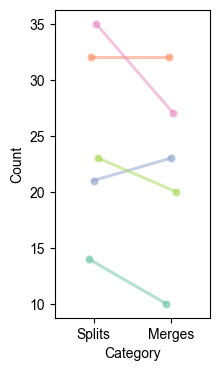

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with paired data
data = pd.DataFrame({
    'Value': lineage_splits + lineage_merges,
    'Category': ['Splits'] * len(lineage_splits) + ['Merges'] * len(lineage_merges),
    'Pair': list(range(len(lineage_splits))) * 2
})

# Plot using Seaborn pointplot without specifying the markers parameter
plt.figure(figsize=(2, 4))
# sns.boxplot(data=data, x='Category', y='Value', color='white', width=0.2, linewidth=1.5)
sns.pointplot(data=data, x='Category', y='Value', hue='Pair', dodge=True, join=True, palette='Set2', scale=0.8, alpha=0.5)

# add a statistical test
from scipy.stats import ttest_rel
splits = data[data['Category'] == 'Splits']['Value']
merges = data[data['Category'] == 'Merges']['Value']

# Adjust legend and labels
plt.legend([],[], frameon=False)  # Hide pair labels in legend if unnecessary
plt.ylabel('Count')
plt.show()


<Axes: >

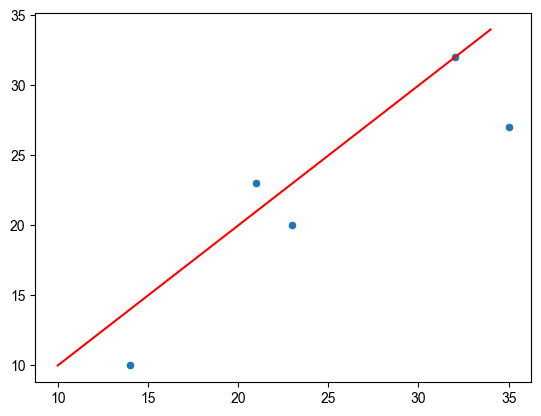

In [19]:
max_merges = np.max(lineage_merges)
max_splits = np.max(lineage_splits)
min_merges = np.min(lineage_merges)
min_splits = np.min(lineage_splits)

sns.scatterplot(x=lineage_splits, y=lineage_merges)
sns.lineplot(x=np.arange(min(min_merges, min_splits), max(max_merges, max_splits)), y=np.arange(min(min_merges, min_splits), max(max_splits, max_merges)), color='red')

Compute lineage lifetimes after split and merges

In [20]:
from collections import deque, defaultdict

def compute_lifetimes_after_splits_and_merges(tracker):
    """Computes the lifetimes of clusters after splits and merges, considering the entire subsequent lineage.

    Args:
        tracker (LineageTracker): An instance of LineageTracker containing the cluster nodes and their relationships.

    Returns:
        Tuple[List[Dict], List[Dict]]: Two lists containing information about splits and merges.
            - splits_info: List of dictionaries with details about each split event.
            - merges_info: List of dictionaries with details about each merge event.
    """
    splits_info = []
    merges_info = []

    # Keep track of nodes we've already processed to avoid duplicates
    processed_splits = set()
    processed_merges = set()

    for node in tracker.nodes.values():
        # Check for splits
        if len(node.children) > 1 and node.cluster_id not in processed_splits:
            split_frame = node.maxframe
            for child in node.children:
                # Compute the maximum frame in the entire subsequent lineage
                max_frame = _get_max_frame_in_lineage(child)
                lifetime_after_split = max_frame - split_frame + 1
                splits_info.append({
                    'split_node_id': node.cluster_id,
                    'split_frame': split_frame,
                    'child_lineage_id': child.lineage_id,
                    'child_minframe': child.minframe,
                    'child_maxframe': max_frame,
                    'lifetime_after_split': lifetime_after_split,
                })
            processed_splits.add(node.cluster_id)

        # Check for merges
        if len(node.parents) > 1 and node.cluster_id not in processed_merges:
            merge_frame = node.minframe
            # Compute the maximum frame in the entire subsequent lineage
            max_frame = _get_max_frame_in_lineage(node)
            lifetime_after_merge = max_frame - merge_frame + 1
            merges_info.append({
                'merge_node_id': node.cluster_id,
                'merge_frame': merge_frame,
                'child_lineage_id': node.lineage_id,
                'child_minframe': node.minframe,
                'child_maxframe': max_frame,
                'lifetime_after_merge': lifetime_after_merge,
                'parent_ids': [parent.cluster_id for parent in node.parents],
            })
            processed_merges.add(node.cluster_id)

    return splits_info, merges_info

def _get_max_frame_in_lineage(start_node):
    """Traverses the lineage starting from start_node and returns the maximum frame.

    Args:
        start_node (ClusterNode): The node from which to start the traversal.

    Returns:
        int: The maximum frame number in the subsequent lineage.
    """
    max_frame = start_node.maxframe
    visited = set()
    stack = [start_node]

    while stack:
        node = stack.pop()
        if node.cluster_id in visited:
            continue
        visited.add(node.cluster_id)
        max_frame = max(max_frame, node.maxframe)
        stack.extend(node.children)

    return max_frame


In [21]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to collect data from all trackers
all_splits = []
all_merges = []

# Loop over each LineageTracker in all_lineages
for tracker in all_lineages:
    # Compute lifetimes after splits and merges for the current tracker
    splits_info, merges_info = compute_lifetimes_after_splits_and_merges(tracker.filter('lineage_duration', 5))
    
    # Convert to DataFrames
    splits_df = pd.DataFrame(splits_info)
    merges_df = pd.DataFrame(merges_info)
    
    # Append to the lists
    all_splits.append(splits_df)
    all_merges.append(merges_df)

# Concatenate all DataFrames into combined DataFrames
combined_splits_df = pd.concat(all_splits, ignore_index=True)
combined_merges_df = pd.concat(all_merges, ignore_index=True)


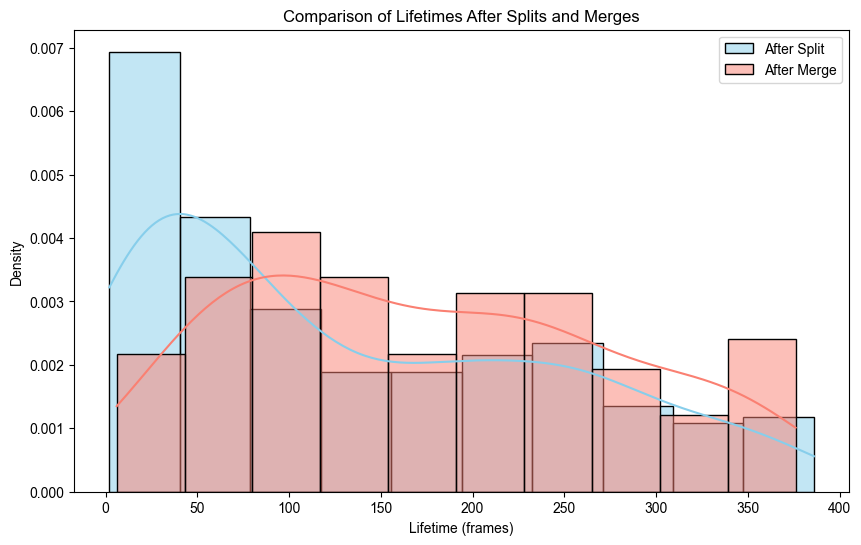

In [22]:
plt.figure(figsize=(10, 6))

# Define number of bins
bins = 10

# Plot histogram for lifetimes after splits
sns.histplot(combined_splits_df['lifetime_after_split'], bins=bins, kde=True, color='skyblue', label='After Split', alpha=0.5, stat='density')
# 
# Plot histogram for lifetimes after merges
sns.histplot(combined_merges_df['lifetime_after_merge'], bins=bins, kde=True, color='salmon', label='After Merge', alpha=0.5, stat='density')

# normalize the histograms
# plt.hist(combined_splits_df['lifetime_after_split'], bins=bins, density=True, alpha=0.5, color='skyblue')
# plt.hist(combined_merges_df['lifetime_after_merge'], bins=bins, density=True, alpha=0.5, color='salmon')

plt.title('Comparison of Lifetimes After Splits and Merges')
plt.xlabel('Lifetime (frames)')
# plt.ylabel('Frequency')
plt.legend()
plt.savefig('split_merge_analysis/lifetime_splits_merges.svg')
plt.show()


In [23]:
combined_lifetimes_df = pd.DataFrame({
    'Lifetime': pd.concat([
        combined_splits_df['lifetime_after_split'],
        combined_merges_df['lifetime_after_merge']
    ], ignore_index=True),
    'Event': ['After Split'] * len(combined_splits_df) + ['After Merge'] * len(combined_merges_df)
})

In [24]:
combined_lifetimes_df

,Lifetime,Event
0,166,After Split
1,166,After Split
2,18,After Split
3,167,After Split
4,256,After Split
...,...,...
396,121,After Merge
397,69,After Merge
398,82,After Merge
399,50,After Merge


C:\Users\benig\AppData\Local\Temp\ipykernel_15076\3777478341.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Event', y='Lifetime', data=combined_lifetimes_df, palette=['skyblue', 'salmon'])


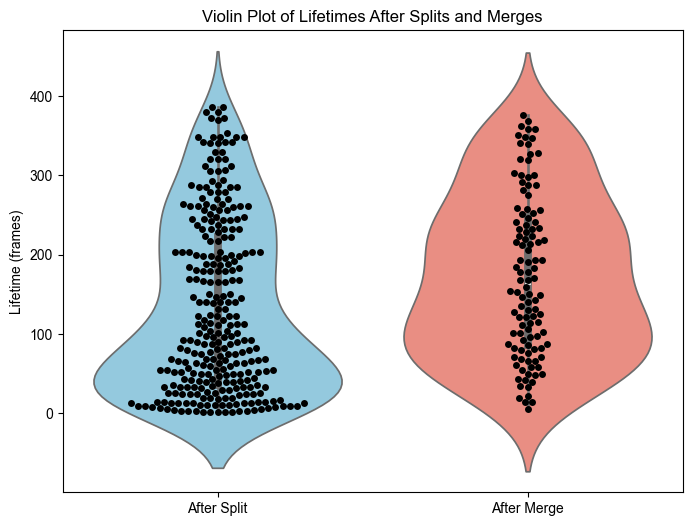

In [25]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Event', y='Lifetime', data=combined_lifetimes_df, palette=['skyblue', 'salmon'])
sns.swarmplot(x='Event', y='Lifetime', data=combined_lifetimes_df, color='k', size=5)
plt.title('Violin Plot of Lifetimes After Splits and Merges')
plt.xlabel('')
plt.ylabel('Lifetime (frames)')
plt.savefig('split_merge_analysis/violin_lifetime_splits_merges.svg')
plt.show()


In [26]:
from scipy.stats import mannwhitneyu


def cohens_d(x, y):
    """Calculate Cohen's d effect size for two samples.

    Args:
        x (array-like): First sample data.
        y (array-like): Second sample data.

    Returns:
        float: Cohen's d effect size.
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.var(x) + (ny - 1) * np.var(y)) / dof)

# Perform the Mann-Whitney U Test
stat, p_value = mannwhitneyu(combined_splits_df['lifetime_after_split'], combined_merges_df['lifetime_after_merge'])

# Calculate Cohen's d effect size
effect_size = cohens_d(combined_splits_df['lifetime_after_split'], combined_merges_df['lifetime_after_merge'])

print(f"Mann-Whitney U Test: U-statistic = {stat}, p-value = {p_value}, Cohen's d = {effect_size}")


Mann-Whitney U Test: U-statistic = 12149.0, p-value = 0.00010681591931075182, Cohen's d = -0.3812584222054031


Compute survival probabilities after split and merges and control for no merges and splits

In [27]:
def compute_lineage_disappearance_probabilities(
    tracker,
    max_frames_after_event=None,
    exclude_last_frame_terminations=False
):
    """
    Computes the probability that a lineage disappears after splits and merges.

    Args:
        tracker (LineageTracker): An instance of LineageTracker.
        max_frames_after_event (int, optional): The maximum number of frames after which
            a lineage is considered to have disappeared. If None, disappearance means
            the lineage has no descendants.
        exclude_last_frame_terminations (bool, optional): If True, lineages that end at the
            last frame are excluded from both the total counts and termination counts.

    Returns:
        Tuple[float, float]: Probabilities for splits and merges, respectively.
    """
    # Determine the last frame in the dataset
    last_frame = max(node.maxframe for node in tracker.nodes.values())

    # For Splits
    total_split_lineages = 0
    disappearing_split_lineages = 0

    for node in tracker.nodes.values():
        if len(node.children) > 1:
            # Split occurs at this node
            event_frame = node.maxframe  # The frame where the split occurs
            for child in node.children:
                # Exclude lineages that end at the last frame if the flag is set
                if exclude_last_frame_terminations and child.maxframe == last_frame:
                    continue  # Exclude from total counts
                total_split_lineages += 1
                if _lineage_terminates(
                    child,
                    max_frames_after_event,
                    event_frame,
                    last_frame,
                    exclude_last_frame_terminations
                ):
                    disappearing_split_lineages += 1

    split_disappearance_probability = (
        disappearing_split_lineages / total_split_lineages if total_split_lineages > 0 else None
    )

    # For Merges
    total_merge_events = 0
    disappearing_merge_lineages = 0

    for node in tracker.nodes.values():
        if len(node.parents) > 1:
            # Merge occurs at this node
            event_frame = node.minframe  # The frame where the merge occurs
            # For each parent lineage
            for parent in node.parents:
                # Exclude lineages that end at the last frame if the flag is set
                if exclude_last_frame_terminations and node.maxframe == last_frame:
                    continue  # Exclude from total counts
                total_merge_events += 1
                if _lineage_terminates(
                    node,
                    max_frames_after_event,
                    event_frame,
                    last_frame,
                    exclude_last_frame_terminations
                ):
                    disappearing_merge_lineages += 1

    merge_disappearance_probability = (
        disappearing_merge_lineages / total_merge_events if total_merge_events > 0 else None
    )

    return split_disappearance_probability, merge_disappearance_probability


def _lineage_terminates(node, max_frames_after_event, event_frame, last_frame, exclude_last_frame_terminations):
    """
    Determines if the lineage starting from the given node terminates within max_frames_after_event frames after event_frame.

    Args:
        node (ClusterNode): The node from which to check lineage termination.
        max_frames_after_event (int or None): The maximum number of frames after which
            the lineage is considered terminated. If None, disappearance means no descendants.
        event_frame (int): The frame at which the event (split or merge) occurred.
        last_frame (int): The last frame in the dataset.
        exclude_last_frame_terminations (bool): If True, lineages ending at the last frame
            are not considered terminated.

    Returns:
        bool: True if the lineage terminates within the specified frames, False otherwise.
    """
    if max_frames_after_event is None:
        # Termination means no descendants
        if not node.children:
            # Exclude lineages that end at the last frame if the flag is set
            if exclude_last_frame_terminations and node.maxframe == last_frame:
                return False  # Lineage may continue; do not consider terminated
            else:
                return True  # Lineage terminates
        else:
            return False  # Lineage continues
    else:
        # If node's maxframe exceeds the allowed frame, lineage continues
        if node.maxframe > event_frame + max_frames_after_event:
            return False  # Lineage continues beyond allowed frames
        # Exclude lineages that end at the last frame if the flag is set
        if exclude_last_frame_terminations and node.maxframe == last_frame:
            return False  # Lineage may continue
        # Recursively check all children
        for child in node.children:
            if not _lineage_terminates(
                child,
                max_frames_after_event,
                event_frame,
                last_frame,
                exclude_last_frame_terminations
            ):
                return False
        return True  # Lineage terminates within allowed frames
    

def compute_lineage_survival_probabilities(
    tracker,
    max_frames_after_event=None,
    exclude_last_frame_terminations=False
):
    """
    Computes the probability that a lineage survives for control (no split/merge) cases.

    Args:
        tracker (LineageTracker): An instance of LineageTracker.
        max_frames_after_event (int, optional): The maximum number of frames to check for survival.
        exclude_last_frame_terminations (bool, optional): If True, lineages that end at the
            last frame are excluded from both total counts and termination counts.

    Returns:
        float: Probability of lineage survival for control cases.
    """
    last_frame = max(node.maxframe for node in tracker.nodes.values())
    total_control_lineages = 0
    surviving_control_lineages = 0

    for node in tracker.nodes.values():
        # Only consider nodes that represent the start of a lineage (no parents)
        # and don't undergo splits or merges
        if (len(node.parents) == 0 and 
            all(len(descendant.children) <= 1 for descendant in _get_all_descendants(node)) and
            all(len(descendant.parents) <= 1 for descendant in _get_all_descendants(node))):
            
            start_frame = node.minframe
            
            # Exclude lineages that end at the last frame if the flag is set
            if exclude_last_frame_terminations and node.maxframe == last_frame:
                continue
                
            total_control_lineages += 1
            
            # Check if the lineage survives
            if not _lineage_terminates(
                node,
                max_frames_after_event,
                start_frame,
                last_frame,
                exclude_last_frame_terminations
            ):
                surviving_control_lineages += 1

    control_survival_probability = (
        surviving_control_lineages / total_control_lineages if total_control_lineages > 0 else None
    )

    return control_survival_probability

def _get_all_descendants(node):
    """Helper function to get all descendants of a node."""
    descendants = set()
    to_process = [node]
    
    while to_process:
        current = to_process.pop()
        descendants.add(current)
        to_process.extend(child for child in current.children if child not in descendants)
    
    return descendants

In [33]:
node = tracker.nodes[108] # example of how to get a node of the lineages, one node represents a single cluster
print('lineage id:', node.lineage_id)
print('cluster id:', node.cluster_id)
print('First frame of cluster appearance:', node.minframe)
print('Last frame of cluster appearance:', node.maxframe)
print('parents:', [parent.cluster_id for parent in node.parents])
print('children:', [child.cluster_id for child in node.children])

lineage id: 55
cluster id: 108
First frame of cluster appearance: 212
Last frame of cluster appearance: 232
parents: [99, 103]
children: [115, 116]


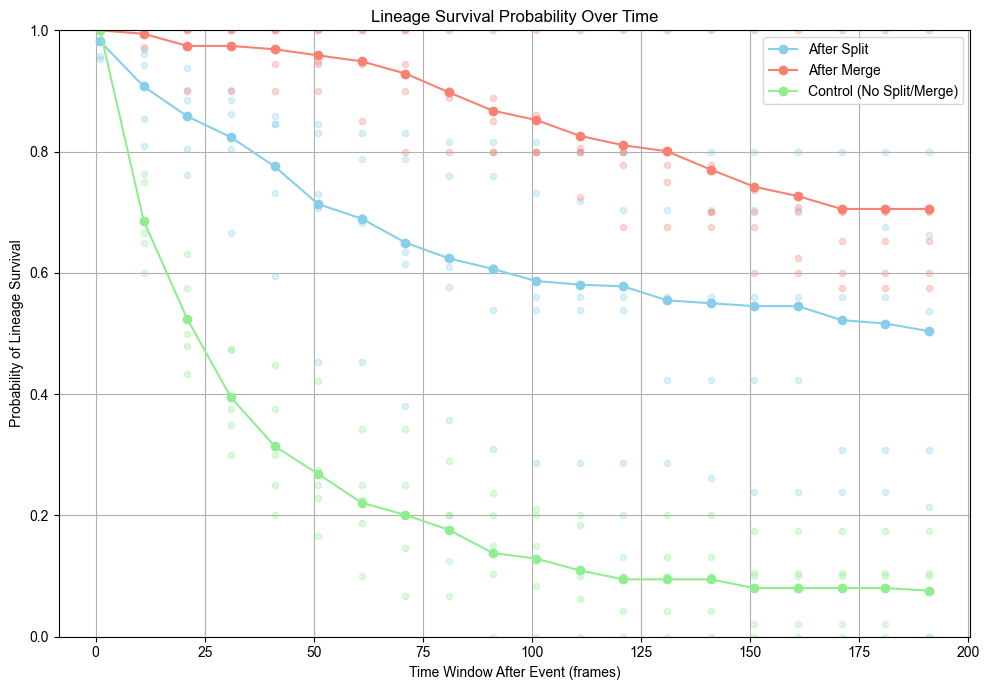

In [34]:
# Modified plotting code
import matplotlib.pyplot as plt
import numpy as np

# Define the range of max_frames_after_event values
max_frames_values = range(1, 200, 10)

# Initialize dictionaries to store probabilities
split_probabilities = {}
merge_probabilities = {}
control_probabilities = {}

# Dictionaries to store lists of individual probabilities
split_probs_individual = {}
merge_probs_individual = {}
control_probs_individual = {}

# Loop over each max_frames_after_event value
for max_frames_after_event in max_frames_values:
    split_probs = []
    merge_probs = []
    control_probs = []
    
    for tracker in all_lineages:
        tracker_filtered = tracker.filter('lineage_duration', 5)
        
        # Compute split and merge probabilities
        split_prob, merge_prob = compute_lineage_disappearance_probabilities(
            tracker_filtered,
            max_frames_after_event=max_frames_after_event,
            exclude_last_frame_terminations=True
        )
        
        # Compute control probabilities
        control_prob = compute_lineage_survival_probabilities(
            tracker_filtered,
            max_frames_after_event=max_frames_after_event,
            exclude_last_frame_terminations=True
        )
        
        if split_prob is not None:
            split_probs.append(1-split_prob)  # Convert to survival probability
        if merge_prob is not None:
            merge_probs.append(1-merge_prob)  # Convert to survival probability
        if control_prob is not None:
            control_probs.append(control_prob)
    
    # Calculate overall probabilities
    split_probabilities[max_frames_after_event] = np.mean(split_probs) if split_probs else np.nan
    merge_probabilities[max_frames_after_event] = np.mean(merge_probs) if merge_probs else np.nan
    control_probabilities[max_frames_after_event] = np.mean(control_probs) if control_probs else np.nan
    
    # Store individual probabilities
    split_probs_individual[max_frames_after_event] = split_probs
    merge_probs_individual[max_frames_after_event] = merge_probs
    control_probs_individual[max_frames_after_event] = control_probs

# Prepare data for plotting
x_values = list(split_probabilities.keys())
split_probs_overall = [split_probabilities[x] for x in x_values]
merge_probs_overall = [merge_probabilities[x] for x in x_values]
control_probs_overall = [control_probabilities[x] for x in x_values]

# Create plot
plt.figure(figsize=(10, 7))

# Plot overall probabilities with different line styles
plt.plot(x_values, split_probs_overall, label='After Split', color='skyblue', marker='o')
plt.plot(x_values, merge_probs_overall, label='After Merge', color='salmon', marker='o')
plt.plot(x_values, control_probs_overall, label='Control (No Split/Merge)', color='lightgreen', marker='o')

# Overlay individual tracker probabilities
for x in x_values:
    # Split probabilities
    y_split = split_probs_individual.get(x, [])
    x_split = [x] * len(y_split)
    plt.scatter(x_split, y_split, color='skyblue', alpha=0.3, s=20)
    
    # Merge probabilities
    y_merge = merge_probs_individual.get(x, [])
    x_merge = [x] * len(y_merge)
    plt.scatter(x_merge, y_merge, color='salmon', alpha=0.3, s=20)
    
    # Control probabilities
    y_control = control_probs_individual.get(x, [])
    x_control = [x] * len(y_control)
    plt.scatter(x_control, y_control, color='lightgreen', alpha=0.3, s=20)

plt.xlabel('Time Window After Event (frames)')
plt.ylabel('Probability of Lineage Survival')
plt.title('Lineage Survival Probability Over Time')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig('split_merge_analysis/lineage_survival_probability_over_time.svg')
plt.show()

Fit a cox proportional hazards model to the data


Checking for separation issues:

split_status:
Variance in event=1 group: 0.2321
Variance in event=0 group: 0.2328

Distribution:
event           0    1
split_status          
0              95  217
1             165  124

merge_status:
Variance in event=1 group: 0.0475
Variance in event=0 group: 0.2328

Distribution:
event           0    1
merge_status          
0             165  324
1              95   17

Basic Statistics:
Total records: 601
Unique lineages: 258

Event counts:
Splits: 289
Merges: 112
Controls: 200
Terminations: 341

Model Results:


<lifelines.CoxTimeVaryingFitter: fitted with 601 periods, 258 subjects, 341 events>
         event col = 'event'
number of subjects = 258
 number of periods = 601
  number of events = 341
partial log-likelihood = -1249.73
  time fit was run = 2024-11-09 14:05:23 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
split_status -1.19      0.30      0.12           -1.43           -0.96                0.24                0.38
merge_status -2.00      0.14      0.26           -2.50           -1.49                0.08                0.22
duration     -4.45      0.01      0.38           -5.19           -3.71                0.01                0.02

              cmp to      z      p  -log2(p)
covariate                                   
split_status    0.00  -9.86 <0.005     73.77
merge_status    0.00  -7.77 <0.005     46.88
duration        0.00 -11.81 <0.005    104.47
---
Partial AIC = 2505.46
log-likelihood ratio test = 290.51 on 3 df
-log2(p) of ll-ratio test = 205.79

None


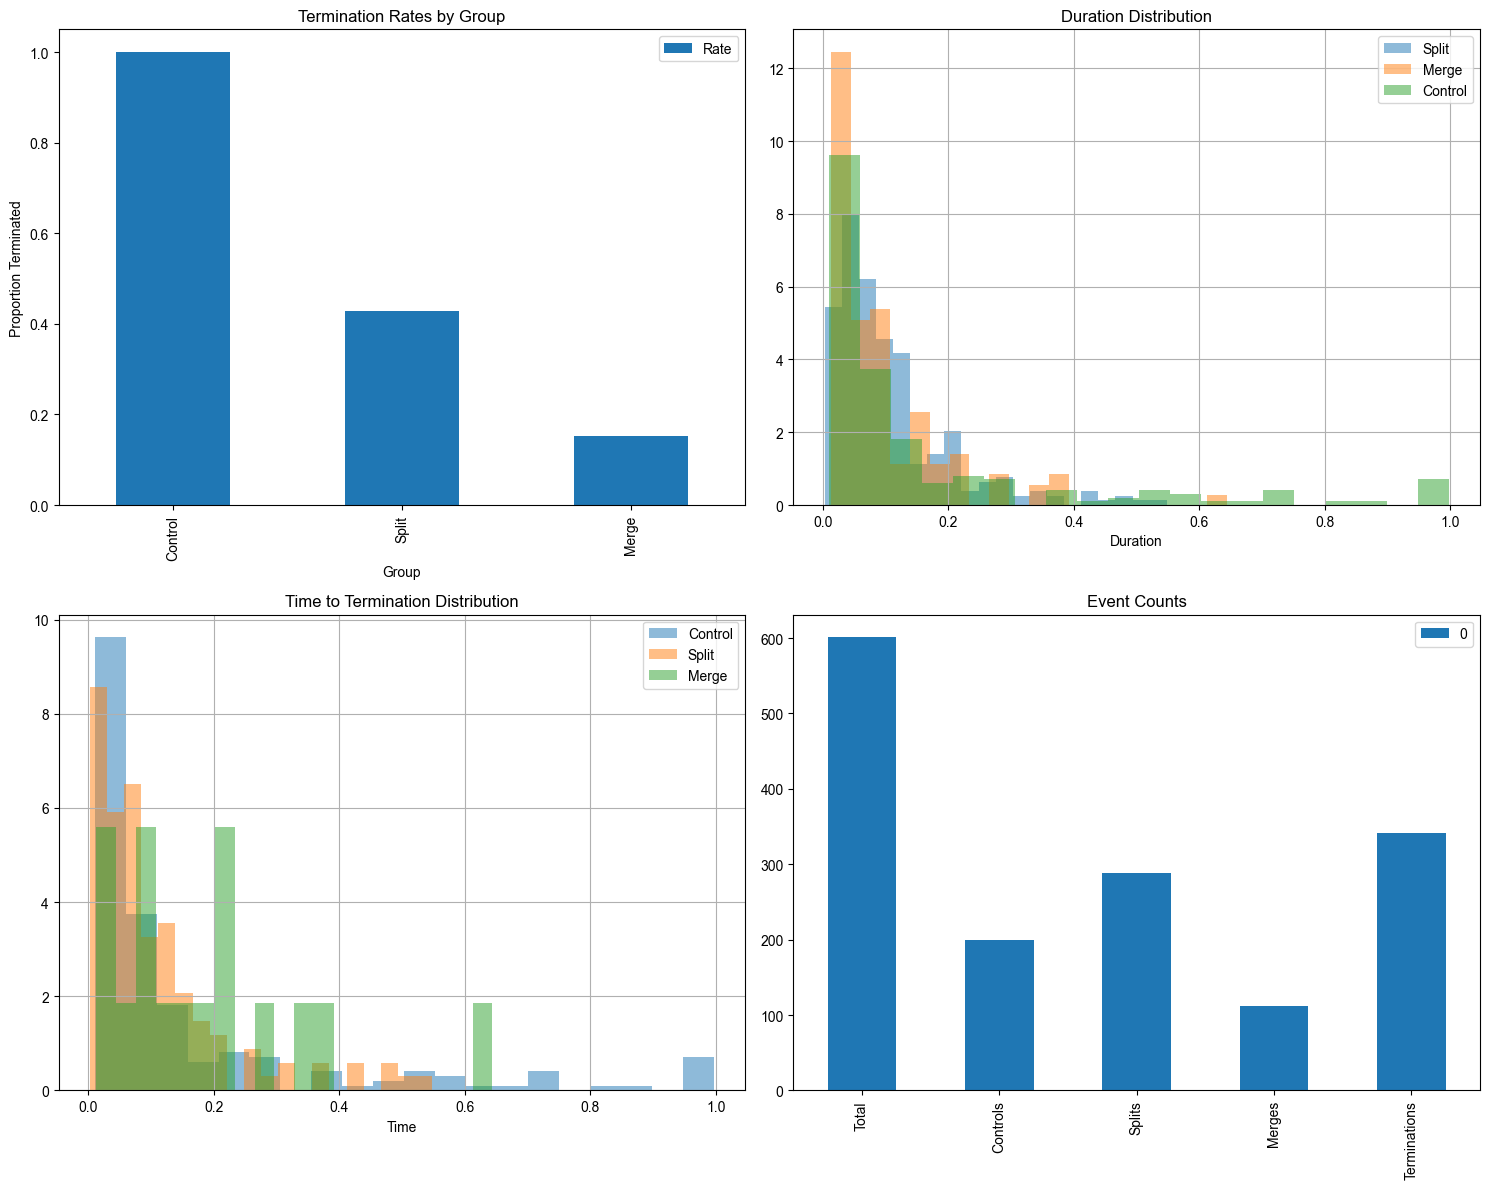

In [36]:
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter
import matplotlib.pyplot as plt
from scipy import stats

def prepare_cox_data(all_lineages):
    """
    Prepares data for Cox analysis, focusing only on split/merge effects.
    """
    records = []
    
    for tracker_idx, tracker in enumerate(all_lineages):
        tracker_filtered = tracker.filter('lineage_duration', 5)
        last_frame = max(node.maxframe for node in tracker_filtered.nodes.values())
        
        # Handle splits - track children after split
        for node in tracker_filtered.nodes.values():
            if len(node.children) > 1:
                split_frame = node.maxframe
                for child in node.children:
                    record = {
                        'id': f"lineage_{child.lineage_id}_{tracker_idx}",  # Removed tracker_idx
                        'start': float(split_frame),
                        'stop': float(child.maxframe),
                        'event': 1 if not child.children else 0,
                        'split_status': 1,
                        'merge_status': 0
                    }
                    records.append(record)
        
        # Handle merges - track merged lineage
        for node in tracker_filtered.nodes.values():
            if len(node.parents) > 1:
                merge_frame = node.minframe
                record = {
                    'id': f"lineage_{node.lineage_id}_{tracker_idx}",  # Removed tracker_idx
                    'start': float(merge_frame),
                    'stop': float(node.maxframe),
                    'event': 1 if not node.children else 0,
                    'split_status': 0,
                    'merge_status': 1
                }
                records.append(record)
        
        # Handle control lineages (no splits/merges)
        for node in tracker_filtered.nodes.values():
            if (len(node.parents) == 0 and 
                all(len(d.children) <= 1 for d in _get_all_descendants(node)) and
                all(len(d.parents) <= 1 for d in _get_all_descendants(node))):
                
                record = {
                    'id': f"lineage_{node.lineage_id}_{tracker_idx}",  # Removed tracker_idx
                    'start': float(node.minframe),
                    'stop': float(node.maxframe),
                    'event': 1 if not node.children else 0,
                    'split_status': 0,
                    'merge_status': 0
                }
                records.append(record)
    
    data = pd.DataFrame(records)
    data = data[data['stop'] > data['start']]
    
    # Scale times
    if not data.empty:
        max_time = max(data['stop'].max(), data['start'].max())
        data['start'] = data['start'] / max_time
        data['stop'] = data['stop'] / max_time
        data['duration'] = data['stop'] - data['start']
    
    # Check for separation issues
    print("\nChecking for separation issues:")
    events = data['event'].astype(bool)
    for col in ['split_status', 'merge_status']:
        var_event = data.loc[events, col].var()
        var_no_event = data.loc[~events, col].var()
        print(f"\n{col}:")
        print(f"Variance in event=1 group: {var_event:.4f}")
        print(f"Variance in event=0 group: {var_no_event:.4f}")
        
        # Print distribution
        print("\nDistribution:")
        print(pd.crosstab(data[col], data['event']))
    
    return data

def plot_termination_patterns(data):
    """
    Creates visualization focusing on termination patterns.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Termination rates by group
    rates = pd.DataFrame({
        'Group': ['Control', 'Split', 'Merge'],
        'Rate': [
            data[(data['split_status'] == 0) & (data['merge_status'] == 0)]['event'].mean(),
            data[data['split_status'] == 1]['event'].mean(),
            data[data['merge_status'] == 1]['event'].mean()
        ]
    })
    rates.plot(kind='bar', x='Group', y='Rate', ax=ax1)
    ax1.set_title('Termination Rates by Group')
    ax1.set_ylabel('Proportion Terminated')
    
    # 2. Duration distributions
    data[data['split_status'] == 1]['duration'].hist(
        ax=ax2, alpha=0.5, label='Split', density=True, bins=20)
    data[data['merge_status'] == 1]['duration'].hist(
        ax=ax2, alpha=0.5, label='Merge', density=True, bins=20)
    data[(data['split_status'] == 0) & (data['merge_status'] == 0)]['duration'].hist(
        ax=ax2, alpha=0.5, label='Control', density=True, bins=20)
    ax2.set_title('Duration Distribution')
    ax2.set_xlabel('Duration')
    ax2.legend()
    
    # 3. Time to termination for each group
    for name, group in [('Control', data[(data['split_status'] == 0) & (data['merge_status'] == 0)]),
                       ('Split', data[data['split_status'] == 1]),
                       ('Merge', data[data['merge_status'] == 1])]:
        terminated = group[group['event'] == 1]['duration']
        if len(terminated) > 0:
            terminated.hist(ax=ax3, alpha=0.5, label=name, density=True, bins=20)
    ax3.set_title('Time to Termination Distribution')
    ax3.set_xlabel('Time')
    ax3.legend()
    
    # 4. Event counts
    counts = pd.DataFrame({
        'Total': [len(data)],
        'Controls': [len(data[(data['split_status'] == 0) & (data['merge_status'] == 0)])],
        'Splits': [len(data[data['split_status'] == 1])],
        'Merges': [len(data[data['merge_status'] == 1])],
        'Terminations': [len(data[data['event'] == 1])]
    }).T
    counts.plot(kind='bar', ax=ax4)
    ax4.set_title('Event Counts')
    
    plt.tight_layout()
    return fig

def analyze_survival(all_lineages):
    """
    Performs survival analysis with focus on termination patterns.
    """
    data = prepare_cox_data(all_lineages)
    
    print("\nBasic Statistics:")
    print(f"Total records: {len(data)}")
    print(f"Unique lineages: {data['id'].nunique()}")
    print("\nEvent counts:")
    print(f"Splits: {(data['split_status'] == 1).sum()}")
    print(f"Merges: {(data['merge_status'] == 1).sum()}")
    print(f"Controls: {((data['split_status'] == 0) & (data['merge_status'] == 0)).sum()}")
    print(f"Terminations: {(data['event'] == 1).sum()}")
    
    # Create visualizations
    fig = plot_termination_patterns(data)
    
    # Fit Cox model
    cph = CoxTimeVaryingFitter()
    
    try:
        cph.fit(
            df=data,
            id_col='id',
            event_col='event',
            start_col='start',
            stop_col='stop'
        )
        
        print("\nModel Results:")
        print(cph.print_summary())
        
        return cph, data
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None, data

# Helper function
def _get_all_descendants(node):
    descendants = set()
    to_process = [node]
    while to_process:
        current = to_process.pop()
        descendants.add(current)
        to_process.extend(child for child in current.children if child not in descendants)
    return descendants

# Run analysis
model, data = analyze_survival(all_lineages)
data.to_csv('split_merge_analysis/survival_data.csv', index=False)

C:\Users\benig\AppData\Local\Temp\ipykernel_15076\4083119057.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  surv[i] = np.exp(-H0_t * rr)


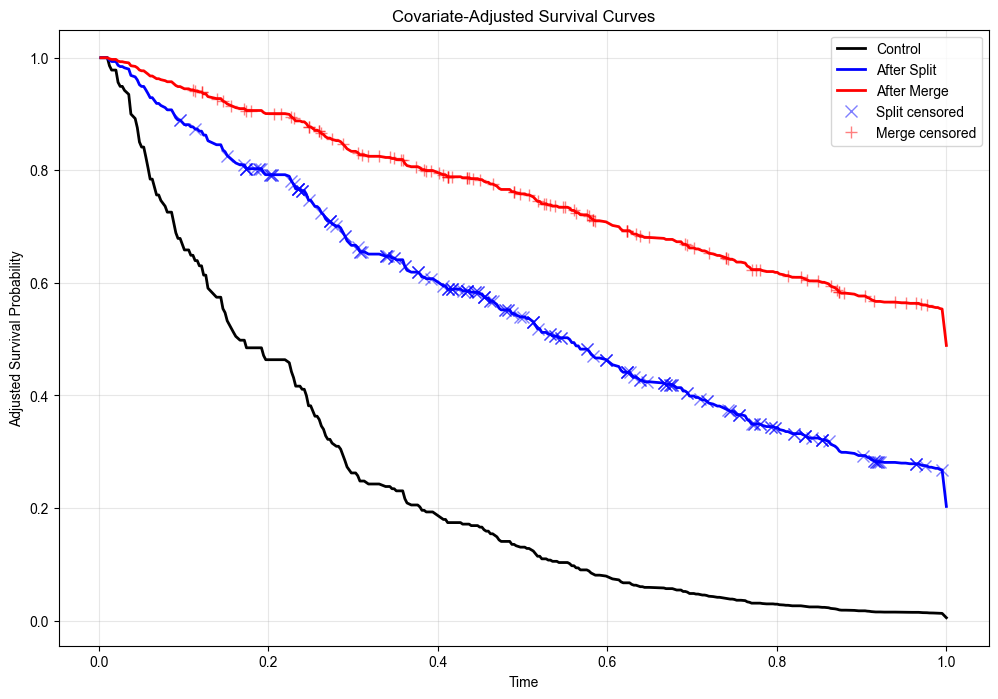

In [53]:
def compute_adjusted_survival_curves(model, data):
    """
    Implementation to compute adjusted survival curves for Cox model.
    """
    # 1. Get baseline cumulative hazard (Nelson-Aalen)
    baseline_hazard = model.baseline_cumulative_hazard_
    
    # 2. Get unique event times
    times = np.sort(np.unique(np.concatenate([data['start'], data['stop']])))
    
    # 3. Create reference profiles
    reference_profiles = [
        {'split_status': 0, 'merge_status': 0, 'duration': 0},  # Control
        {'split_status': 1, 'merge_status': 0, 'duration': 0},  # Split
        {'split_status': 0, 'merge_status': 1, 'duration': 0}   # Merge
    ]
    
    def compute_survival(profile):
        # Get linear predictor
        lp = (model.params_['split_status'] * profile['split_status'] +
              model.params_['merge_status'] * profile['merge_status'] +
              model.params_['duration'] * profile['duration'])
        
        # Compute relative risk
        rr = np.exp(lp)
        
        # Get survival probabilities
        surv = np.zeros(len(times))
        for i, t in enumerate(times):
            # Find cumulative hazard up to time t
            h0_t = baseline_hazard[baseline_hazard.index <= t]
            if len(h0_t) > 0:
                H0_t = h0_t.iloc[-1]
                # Adjusted survival probability
                surv[i] = np.exp(-H0_t * rr)
            else:
                surv[i] = 1.0
        
        return surv
    
    # Compute survival curves for each profile
    survival_curves = [compute_survival(profile) for profile in reference_profiles]
    
    return times, survival_curves

def plot_adjusted_curves(model, data):
    """
    Plot survival curves adjusted for covariates.
    """
    times, curves = compute_adjusted_survival_curves(model, data)
    
    plt.figure(figsize=(12, 8))
    labels = ['Control', 'After Split', 'After Merge']
    colors = ['black', 'blue', 'red']
    
    # Plot each curve
    for curve, label, color in zip(curves, labels, colors):
        plt.plot(times, curve, '-', label=label, color=color, linewidth=2)
    
    # Add censoring markers
    for group, symbol, color in [('Split', 'x', 'blue'), 
                                ('Merge', '+', 'red')]:
        mask = data[f'{group.lower()}_status'] == 1
        censored = data[mask & (data['event'] == 0)]
        
        if len(censored) > 0:
            # Find corresponding survival probabilities
            group_idx = 1 if group == 'Split' else 2
            censor_times = censored['stop']
            censor_probs = [curves[group_idx][np.searchsorted(times, t)] 
                          for t in censor_times]
            
            plt.plot(censor_times, censor_probs,
                    symbol, color=color, markersize=8,
                    label=f'{group} censored', alpha=0.5)
    
    plt.xlabel('Time')
    plt.ylabel('Adjusted Survival Probability')
    plt.title('Covariate-Adjusted Survival Curves')
    plt.grid(True, alpha=0.3)
    plt.legend()

plot_adjusted_curves(model, data)
plt.savefig('split_merge_analysis/adjusted_survival_curves.svg')

In [ ]:
# plot durations of 

Plot a lineage tree with split and merge events

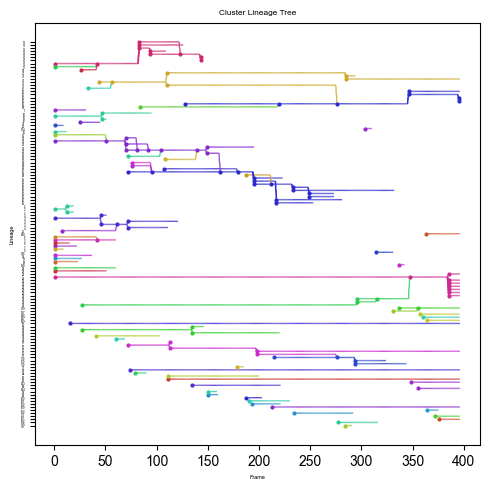

In [37]:
filtered_l = all_lineages[4].filter('lineage_duration', 5)
filtered_l.plot(font_size=6, figsize=(5, 5), edge_width=1, node_size=4)
plt.savefig('split_merge_analysis/lineage_4.svg')

Function definitions for extracting lineage information centered and normalized to split and merge events (i.e. intensity of actin before and after events)

In [ ]:
from skimage.measure import regionprops_table

def collect_cluster_ids(node, start_frame, end_frame):
    """
    Collects cluster IDs for a node from start_frame to end_frame inclusive.
    """
    frames = range(max(node.minframe, start_frame), min(node.maxframe, end_frame) + 1)
    return [(frame, node.cluster_id) for frame in frames]



def traverse_lineage(node, remaining_frames, direction, collected_frames):
    """
    Recursively traverses the lineage to collect cluster IDs over frames.

    Args:
        node (ClusterNode): The current node.
        remaining_frames (int): Number of frames left to collect.
        direction (str): 'backward' or 'forward'.
        collected_frames (dict): Dictionary mapping frames to cluster IDs.
    """
    if remaining_frames <= 0 or node is None:
        return

    # Determine frames to collect for this node
    if direction == 'backward':
        frames = range(node.maxframe, node.minframe - 1, -1)
        next_nodes = node.parents
    elif direction == 'forward':
        frames = range(node.minframe, node.maxframe + 1)
        next_nodes = node.children
    else:
        raise ValueError("Direction must be 'backward' or 'forward'.")

    for frame in frames:
        if frame not in collected_frames:
            collected_frames[frame] = node.cluster_id
            remaining_frames -= 1
            if remaining_frames <= 0:
                return collected_frames

    # Recursively traverse to next nodes
    for next_node in next_nodes:
        collected_frames = traverse_lineage(next_node, remaining_frames, direction, collected_frames)
        if remaining_frames <= 0:
            return collected_frames

def extract_metrics(seg_images, intensity_images, frames_and_ids, event_frame):
    """
    Extracts area and intensity metrics for given cluster IDs over specified frames.

    Args:
        seg_images (np.ndarray): Segmentation images of shape (num_frames, height, width).
        intensity_images (np.ndarray): Intensity images of same shape as seg_images.
        frames_and_ids (list of tuples): List of (frame, cluster_id) tuples.
        event_frame (int): The frame at which the event occurs.

    Returns:
        metrics (dict): Dictionary containing 'area', 'intensity_mean', and 'frame_indices'.
    """
    total_frames = len(frames_and_ids)
    area = np.zeros(total_frames)
    intensity_mean = np.zeros(total_frames)
    frame_indices = []

    for idx, (frame, cluster_id) in enumerate(frames_and_ids):
        relative_frame = frame - event_frame
        frame_indices.append(relative_frame)
        if 0 <= frame < seg_images.shape[0]:
            seg_image = seg_images[frame]
            intensity_image = intensity_images[frame] if intensity_images is not None else None
            mask = seg_image == cluster_id
            if np.any(mask):
                props = regionprops_table(mask.astype(int), intensity_image=intensity_image, properties=['area', 'mean_intensity'])
                area[idx] = props['area'][0]
                intensity_mean[idx] = props['mean_intensity'][0] if intensity_image is not None else np.nan
            else:
                area[idx] = 0
                intensity_mean[idx] = 0
        else:
            area[idx] = 0
            intensity_mean[idx] = 0

    return {
        'area': area,
        'intensity_mean': intensity_mean,
        'frame_indices': frame_indices
    }



In [ ]:
def collect_trace_backward(node, n_frames, event_frame):
    """
    Collects a trace backwards from event frame, padding with nan if needed.
    
    Args:
        node (ClusterNode): Starting node
        n_frames (int): Number of frames to collect before event
        event_frame (int): Frame where event occurs
    
    Returns:
        dict: Mapping of frame -> cluster_id, padded with nan if needed
    """
    collected_frames = {}
    target_start = event_frame - n_frames
    current_node = node
    current_frame = event_frame
    
    while current_frame >= target_start:
        # If we're within current node's frames
        if current_frame >= current_node.minframe:
            collected_frames[current_frame] = current_node.cluster_id
            current_frame -= 1
        # If we need to go to parent
        elif current_node.parents:
            # Take first parent for now (could be extended to handle multiple parents)
            current_node = current_node.parents[0]
        # If we've reached the end of the trace but still need frames
        else:
            # Pad remaining frames with nan
            while current_frame >= target_start:
                collected_frames[current_frame] = np.nan
                current_frame -= 1
            break
            
    return collected_frames

def collect_trace_forward(node, n_frames, event_frame):
    """
    Collects a trace forwards from event frame, padding with nan if needed.
    
    Args:
        node (ClusterNode): Starting node
        n_frames (int): Number of frames to collect after event
        event_frame (int): Frame where event occurs
    
    Returns:
        dict: Mapping of frame -> cluster_id, padded with nan if needed
    """
    collected_frames = {}
    target_end = event_frame + n_frames
    current_node = node
    current_frame = event_frame + 1  # Start from frame after event
    
    while current_frame <= target_end:
        # If we're within current node's frames
        if current_frame <= current_node.maxframe:
            collected_frames[current_frame] = current_node.cluster_id
            current_frame += 1
        # If we need to go to child
        elif current_node.children:
            # Take first child for this particular trace
            current_node = current_node.children[0]
        # If we've reached the end of the trace but still need frames
        else:
            # Pad remaining frames with nan
            while current_frame <= target_end:
                collected_frames[current_frame] = np.nan
                current_frame += 1
            break
            
    return collected_frames

def collect_lineage_traces(node, n_frames_before, n_frames_after, event_frame):
    """
    Collects all possible traces through a lineage node.
    For splits: one trace per child sharing same parent trace
    For merges: one trace per parent sharing same child trace
    
    Args:
        node: Node where event occurs
        n_frames_before: Number of frames to collect before event
        n_frames_after: Number of frames to collect after event
        event_frame: Frame where event occurs
    """
    traces = []
    trace_id = 0
    
    # First collect the backward trace (will be shared by all children in case of split)
    backward_trace = collect_trace_backward(node, n_frames_before, event_frame)
    
    # Add event frame to backward trace
    backward_trace[event_frame] = node.cluster_id
    
    # For each child (in case of split) or parent (in case of merge)
    if len(node.children) > 1:  # Split
        for child in node.children:
            # Create new trace for this child
            forward_trace = collect_trace_forward(child, n_frames_after, event_frame)
            
            # Combine backward and forward traces
            full_trace = backward_trace.copy()
            full_trace.update(forward_trace)
            
            # Convert to sorted lists
            frames_and_ids = sorted(full_trace.items())
            trace = {
                'frames': [f for f, _ in frames_and_ids],
                'cluster_ids': [c for _, c in frames_and_ids],
                'trace_id': trace_id
            }
            traces.append(trace)
            trace_id += 1
            
    elif len(node.parents) > 1:  # Merge
        for parent in node.parents:
            # Create new trace for this parent
            parent_trace = collect_trace_backward(parent, n_frames_before, event_frame)
            
            # Collect forward trace (will be shared by all parents)
            forward_trace = collect_trace_forward(node, n_frames_after, event_frame)
            
            # Combine traces
            full_trace = parent_trace.copy()
            full_trace[event_frame] = node.cluster_id
            full_trace.update(forward_trace)
            
            # Convert to sorted lists
            frames_and_ids = sorted(full_trace.items())
            trace = {
                'frames': [f for f, _ in frames_and_ids],
                'cluster_ids': [c for _, c in frames_and_ids],
                'trace_id': trace_id
            }
            traces.append(trace)
            trace_id += 1
    
    return traces

def extract_metrics(seg_images, intensity_images, frames_and_ids, event_frame):
    """
    Extracts area and intensity metrics for given cluster IDs over specified frames.
    Handles nan values in cluster_ids and adjusts for 0-based array indexing.
    
    Args:
        seg_images (np.ndarray): Segmentation images array (0-based indexing)
        intensity_images (np.ndarray): Intensity images array (0-based indexing)
        frames_and_ids (list): List of (frame, cluster_id) tuples (1-based frame numbers)
        event_frame (int): Frame where event occurs (1-based frame number)
    """
    total_frames = len(frames_and_ids)
    area = np.zeros(total_frames)
    intensity_mean = np.zeros(total_frames)
    frame_indices = []
    
    for idx, (frame, cluster_id) in enumerate(frames_and_ids):
        relative_frame = frame - event_frame
        frame_indices.append(relative_frame)
        
        # Handle nan cluster_ids
        if np.isnan(cluster_id):
            area[idx] = np.nan
            intensity_mean[idx] = np.nan
            continue
        
        # Convert 1-based frame number to 0-based array index
        array_idx = frame - 1
            
        if 0 <= array_idx < seg_images.shape[0]:
            seg_image = seg_images[array_idx]  # Use 0-based index
            intensity_image = intensity_images[array_idx] if intensity_images is not None else None
            mask = seg_image == cluster_id
            
            if np.any(mask):
                props = regionprops_table(mask.astype(int), 
                                        intensity_image=intensity_image, 
                                        properties=['area', 'mean_intensity'])
                area[idx] = props['area'][0]
                intensity_mean[idx] = props['mean_intensity'][0] if intensity_image is not None else np.nan
            else:
                area[idx] = 0
                intensity_mean[idx] = 0
        else:
            area[idx] = np.nan
            intensity_mean[idx] = np.nan
            
    return {
        'area': area,
        'intensity_mean': intensity_mean,
        'frame_indices': frame_indices
    }

In [ ]:
def analyze_all_lineages(all_lineages, all_events, lifeact_bl, n_frames_before, n_frames_after):
    """
    Process all lineages and collect data for all events.
    Now maintains unique trace IDs across all events.
    
    Args:
        all_lineages (list): List of LineageTracker objects 
        all_events (list): List of segmentation images per tracker
        lifeact_bl (list): List of intensity images per tracker
        n_frames_before (int): Number of frames to analyze before each event
        n_frames_after (int): Number of frames to analyze after each event
    
    Returns:
        pd.DataFrame: Combined data for all events
    """
    all_event_data = []
    global_trace_id = 0  # Keep track of trace IDs across all events
    
    # Process each tracker
    for tracker_index, tracker in enumerate(all_lineages):
        tracker_seg_images = all_events[tracker_index]
        tracker_intensity_images = lifeact_bl[tracker_index]
        
        # Find splits and merges
        for node in tracker.nodes.values():
            # Handle splits (nodes with multiple children)
            if len(node.children) > 1:
                event_frame = node.maxframe  # Event happens at last frame of node
                traces = collect_lineage_traces(
                    node, 
                    n_frames_before, 
                    n_frames_after, 
                    event_frame
                )
                
                # Process each trace with global trace ID
                for trace in traces:
                    frames = trace['frames']
                    cluster_ids = trace['cluster_ids']
                    
                    # Extract metrics
                    metrics = extract_metrics(
                        tracker_seg_images,
                        tracker_intensity_images,
                        list(zip(frames, cluster_ids)),
                        event_frame
                    )
                    
                    # Create records with global trace ID
                    for i in range(len(frames)):
                        record = {
                            'frame': frames[i],
                            'frame_relative': metrics['frame_indices'][i],
                            'trace_id': global_trace_id,  # Use global trace ID
                            'cluster_id': cluster_ids[i],
                            'area': metrics['area'][i],
                            'intensity_mean': metrics['intensity_mean'][i],
                            'event_type': 'split',
                            'tracker_id': tracker_index,
                            'event_frame': event_frame
                        }
                        all_event_data.append(record)
                    global_trace_id += 1  # Increment after each trace
            
            # Handle merges (nodes with multiple parents)
            elif len(node.parents) > 1:
                event_frame = node.minframe  # Event happens at first frame of node
                traces = collect_lineage_traces(
                    node, 
                    n_frames_before, 
                    n_frames_after, 
                    event_frame
                )
                
                # Process each trace with global trace ID
                for trace in traces:
                    frames = trace['frames']
                    cluster_ids = trace['cluster_ids']
                    
                    # Extract metrics
                    metrics = extract_metrics(
                        tracker_seg_images,
                        tracker_intensity_images,
                        list(zip(frames, cluster_ids)),
                        event_frame
                    )
                    
                    # Create records with global trace ID
                    for i in range(len(frames)):
                        record = {
                            'frame': frames[i],
                            'frame_relative': metrics['frame_indices'][i],
                            'trace_id': global_trace_id,  # Use global trace ID
                            'cluster_id': cluster_ids[i],
                            'area': metrics['area'][i],
                            'intensity_mean': metrics['intensity_mean'][i],
                            'event_type': 'merge',
                            'tracker_id': tracker_index,
                            'event_frame': event_frame
                        }
                        all_event_data.append(record)
                    global_trace_id += 1  # Increment after each trace
    
    # Combine all data into DataFrame
    if all_event_data:
        final_df = pd.DataFrame(all_event_data)
        return final_df
    else:
        return pd.DataFrame()

# Modified plotting function to handle multiple events
def plot_event_traces(df, event_frame=None, tracker_id=None):
    """
    Plot traces for events, optionally filtered by event_frame and tracker_id.
    
    Args:
        df: DataFrame with trace data
        event_frame: Optional specific event frame to plot
        tracker_id: Optional specific tracker ID to plot
    """
    # Filter data if specified
    plot_data = df.copy()
    if event_frame is not None:
        plot_data = plot_data[plot_data['event_frame'] == event_frame]
    if tracker_id is not None:
        plot_data = plot_data[plot_data['tracker_id'] == tracker_id]
    
    # Create subplots for each event
    unique_events = plot_data.groupby(['event_frame', 'tracker_id'])
    n_events = len(unique_events)
    
    if n_events == 0:
        print("No events found matching criteria")
        return
    
    fig, axes = plt.subplots(n_events, 2, figsize=(15, 5*n_events))
    if n_events == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ((evt_frame, tr_id), event_data) in enumerate(unique_events):
        # Plot area
        sns.lineplot(
            data=event_data,
            x='frame_relative',
            y='area',
            hue='trace_id',
            ax=axes[idx, 0]
        )
        axes[idx, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        axes[idx, 0].set_title(f'Area Traces - Event at Frame {evt_frame} (Tracker {tr_id})')
        
        # Plot intensity
        sns.lineplot(
            data=event_data,
            x='frame_relative',
            y='intensity_mean',
            hue='trace_id',
            ax=axes[idx, 1]
        )
        axes[idx, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        axes[idx, 1].set_title('Intensity Traces')
    
    plt.tight_layout()
    plt.show()


# Process all lineages
results_df = analyze_all_lineages(all_lineages, all_events, lifeact_bl, 10, 10)

# Plot specific event
plot_event_traces(results_df, event_frame=216, tracker_id=0)

# Or plot all events
# plot_event_traces(results_df)

perform hera clustering on lineage data

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_hierarchical_cluster_plot(df, metric='intensity_mean_normalized', event_type='merge'):
    """
    Creates a hierarchical cluster plot of traces, clustering based only on post-event frames.
    
    Args:
        df: DataFrame with trace data
        metric: Column name of metric to plot
        event_type: Type of event to plot ('merge' or 'split')
    """
    # Filter data
    plot_data = df.query(f'event_type == "{event_type}"').copy()
    
    # Pivot data to get traces as rows and frame_relative as columns
    pivot_data = plot_data.pivot(
        index='trace_id',
        columns='frame_relative',
        values=metric
    )
    
    # For clustering, only use frames after the event (frame_relative >= 0)
    clustering_data = pivot_data
    
    # Calculate linkage matrix using only post-event data
    from scipy.cluster.hierarchy import linkage
    row_linkage = linkage(clustering_data, method='ward', metric='euclidean')
    
    # Create hierarchical cluster plot using the linkage matrix
    # but display all frames
    g = sns.clustermap(
        pivot_data,  # Show all data
        row_linkage=row_linkage,  # Use linkage based on post-event frames
        metric='euclidean',      
        figsize=(15, 10),
        cmap='PiYG',            
        standard_scale=False,    
        dendrogram_ratio=0.2,    
        row_cluster=True,        
        col_cluster=False,       
        xticklabels=True,
        yticklabels=False,
    )
    
    # Customize plot
    g.ax_heatmap.set_xlabel('Frames relative to event')
    g.ax_heatmap.set_ylabel('Traces (clustered)')
    g.ax_heatmap.axvline(x=pivot_data.columns.get_loc(0), color='black', linestyle='--', alpha=0.5)
    
    # Add title
    plt.suptitle(f'Hierarchical Clustering of {event_type.capitalize()} Event Traces\n{metric}',
                y=1.02)
    
    return g


# First normalize the intensity values if not already done
def normalize_traces(df):
    """
    Normalizes values within each trace to its mean value before the event.
    """
    # Group by trace and normalize
    def normalize_group(group):
        # Get pre-event mean (negative frame_relative values)
        pre_event_mean = group[group['frame_relative'] < 0][['intensity_mean', 'area']].median()
        
        # Normalize both metrics
        group['intensity_mean_normalized'] = group['intensity_mean'] / pre_event_mean['intensity_mean']
        group['area_normalized'] = group['area'] / pre_event_mean['area']
        return group
    
    return df.groupby(['trace_id', 'event_type']).apply(normalize_group)

results_filtered = results_df.query('event_frame < 396-10 and event_frame > 10')
# Normalize data and create plot
results_df_normalized = normalize_traces(results_filtered)
# remove things ending at last frame

results_df_normalized.fillna(0, inplace=True)

# Create hierarchical cluster plot for merge events
g_merge = create_hierarchical_cluster_plot(
    results_df_normalized, 
    metric='intensity_mean',
    event_type='merge'
)

# Create hierarchical cluster plot for split events
g_split = create_hierarchical_cluster_plot(
    results_df_normalized, 
    metric='intensity_mean',
    event_type='split'
)

plt.show()

# Optional: You can also create plots for area
g_merge_area = create_hierarchical_cluster_plot(
    results_df_normalized, 
    metric='area',
    event_type='merge'
)

g_split_area = create_hierarchical_cluster_plot(
    results_df_normalized, 
    metric='area',
    event_type='split'
)

plt.show()

In [ ]:
results_df_normalized

plot individual traces normalized to split and merge events

In [ ]:
g = sns.FacetGrid(results_df.dropna(), col='event_type', height=5, sharey=False)

g.map_dataframe(sns.lineplot, x='frame_relative', y='intensity_mean', estimator='mean', errorbar='sd', palette='Accent', hue='trace_id')

In [ ]:
plt.rcParams['svg.fonttype'] = 'none'
# set font to arial
plt.rcParams['font.sans-serif'] = "Arial"


fig, ax = plt.subplots(2,3, figsize=(7,5))

for idx, val in enumerate(samples):
    ax[0, idx].imshow(rbg_lifeact[idx])
    ax[0, idx].set_xticks([])
    ax[0, idx].set_yticks([])
    # in minutes
    ax[0, idx].set_title(f'{val*1/60:.0f} min')

for idx, val in enumerate(samples):
    ax[1, idx].imshow(rgb_events[idx])
    ax[1, idx].set_xticks([])
    ax[1, idx].set_yticks([])
    if val == samples[-1]:
        scalebar = ScaleBar(0.15, "um", length_fraction=0.2, location='lower right', scale_loc="none", box_alpha=0, width_fraction=0.025)
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-0)
plt.savefig('plots/pannels.svg', dpi=600)
# scalebar = 5 um

In [ ]:
from napari_timestamper import render_as_rgb
# make crop of single event and follow it over time with high temporal resolution

# get the event id
event_id = 15

# get the frames of the event
event_frames = np.where(all_events_filtered == event_id)

# get the first frame of the event
first_frame = event_frames[0][0]

# get bounding box of the event
bbox = ndimage.find_objects(all_events_filtered == event_id)[0]
# add 10 pixels to the bounding box
bbox = tuple(slice(max(0, i.start-5), min(i.stop+5, j)) for i, j in zip(bbox, all_events_filtered.shape))


# crop the event
cropped_event_actin = lifeact_bl[bbox]
cropped_event = all_events_filtered[bbox]
# plot 10 frames as a sequence of the event cropped to the bounding box
# add to napari viewer
viewer = napari.Viewer()
viewer.add_image(cropped_event_actin, name="actin", colormap="gray_r")
viewer.add_labels(cropped_event, name="tracked waves")



In [ ]:
# create rgb images of the event

rgb_event = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.layers["tracked waves"].visible = False
rgb_actin_only = render_as_rgb(viewer, axis=0, upsample_factor=4)

In [ ]:
all_events_filtered.shape

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 6, figsize=(5, 2), dpi=150)
for idx, val in enumerate(range(first_frame, first_frame + 120, 20)):
    ax[idx].imshow(rgb_event[val])
    # remove ticks
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    # Add text to the upper left corner
    ax[idx].text(0.05, 0.95, f'{val*1:.0f} sec', transform=ax[idx].transAxes,
                    fontsize=6, verticalalignment='top', horizontalalignment='left')
    ax[idx].margins(0, 0)

plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig("plots/event_sequence.svg", dpi=600)
plt.show()


## Plot Kymograph

In [ ]:
def project_labels(label_image: np.ndarray, axis: int, y_scale: int =1):
  """
  Projects image along a specified axis.

  Parameters:
    label_image: A NumPy array of shape (t, y, x) representing the label image.
    axis: An integer specifying the axis along which to project (0 for time, 1 for y, 2 for x).
    y_scale: integer how many times the y_axis should be sampled

  Returns:
    A NumPy array of shape (y, t) or (x, t) representing the projected label image.
  """
  if axis >= label_image.ndim:
      raise ValueError("Invalid axis: {}".format(axis))
  projection = label_image.max(axis=axis)
  # projection = np.where(projection == 0, np.nan, projection)
  return np.repeat(projection, y_scale, axis=0)

In [ ]:
viewer = napari.Viewer()
viewer.add_labels(project_labels(filtered_events, 2))
noodles_rbg = render_as_rgb(viewer, upsample_factor=1)
viewer.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(noodles_rbg, cmap='tab20', vmin=1, vmax=3, interpolation='none', aspect=0.7)
ax.set_xlabel('X-Axis')
ax.invert_yaxis()

# Get the original y-ticks
original_ticks = ax.get_yticks()

# Assuming 'noodles_rbg' is a 2D array, get the current y-axis limit
y_max = noodles_rbg.shape[0]

# Convert these ticks to minutes and format using f-strings without units
new_tick_labels = [f"{(tick * 3) / 60:.0f}" for tick in original_ticks]  # Multiply by 10 to adjust the scale

# Set the new ticks and labels
# ax.set_yticks(original_ticks)
ax.set_yticklabels(new_tick_labels)

ax.set_ylabel('Time [min]')

plt.tight_layout()
plt.savefig('plots/noodles.svg', dpi=600)

In [ ]:
from skimage import transform
viewer = napari.Viewer()

viewer.add_image(project_labels(lifeact, 2), colormap='gray_r')
l = viewer.add_labels(project_labels(events, 2))
l.contour = 3

noodles_rbg_rGBD = render_as_rgb(viewer, upsample_factor=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(noodles_rbg_rGBD, interpolation='none', aspect=0.7)
# Get the original y-ticks
original_ticks = ax.get_yticks()

# Assuming 'noodles_rbg' is a 2D array, get the current y-axis limit
y_max = noodles_rbg.shape[0]

# Convert these ticks to minutes and format using f-strings without units
new_tick_labels = [f"{(tick * 3) / 60:.0f}" for tick in original_ticks]  # Multiply by 10 to adjust the scale

# Set the new ticks and labels
# ax.set_yticks(original_ticks)
ax.set_yticklabels(new_tick_labels)

ax.set_ylabel('Time [min]')
ax.set_xlabel('X-Axis')
ax.invert_yaxis()
# ax.set_xlim(100, 800)
plt.tight_layout()
plt.savefig('plots/noodles_bg_removed.svg', dpi=600)

In [ ]:
from skimage import transform
viewer = napari.Viewer()

viewer.add_image(project_labels(lifeact, 2), colormap='gray_r')

max_rGBD = render_as_rgb(viewer, upsample_factor=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.imshow(max_rGBD, interpolation='none', aspect=0.7)
# Get the original y-ticks
original_ticks = ax.get_yticks()

# Assuming 'noodles_rbg' is a 2D array, get the current y-axis limit
y_max = noodles_rbg.shape[0]

# Convert these ticks to minutes and format using f-strings without units
new_tick_labels = [f"{(tick * 3) / 60:.0f}" for tick in original_ticks]  # Multiply by 10 to adjust the scale

# Set the new ticks and labels
# ax.set_yticks(original_ticks)
ax.set_yticklabels(new_tick_labels)

ax.set_ylabel('Time [min]')
ax.set_xlabel('X-Axis')
ax.invert_yaxis()
# ax.set_xlim(100, 800)
plt.tight_layout()
plt.savefig('plots/raw_max_proj.svg', dpi=600)

In [ ]:
from skimage.measure import regionprops_table
# plot centroid xy projection of the filtered events
all_dfs = []
for idx_pos, pos in enumerate(all_events_filtered):
    for idx, frame in enumerate(pos):
        props = regionprops_table(frame, properties=('label', 'centroid', 'area'))
        df = pd.DataFrame(props)
        df['frame'] = idx
        df['position'] = idx_pos
        all_dfs.append(df)

df = pd.concat(all_dfs)
df['x'] = df['centroid-1']
df['y'] = df['centroid-0']
df = df.drop(columns=['centroid-0', 'centroid-1'])

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
for name, group in df.groupby(['label', 'position']):
    # set first from to 0,0
    group['x'] = group['x'] - group['x'].iloc[0]
    group['y'] = group['y'] - group['y'].iloc[0]
    ax.plot(group['x'], group['y'], label=name, lw=0.5)

# convert axis to um
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}".format(x*0.15)))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}".format(x*0.15)))
ax.set_ylabel('Y-Axis [µm]')
ax.set_xlabel('X-Axis [µm]')

ax.set_aspect('equal')


plt.tight_layout()
plt.savefig('plots/centroid_projection.svg', dpi=600)


In [ ]:
df.groupby(['label', 'position'])['frame'].transform('count')

In [ ]:
df.frame.max()

In [ ]:
# filter out tracks of small area
# df = df[df.groupby('label')['area'].transform('mean') > 5]




# plot histogram of the track duration
duration = df.groupby(['label', 'position'])['frame'].count() * 1 / 60
# log scale
# duration = np.log10(duration)
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist(duration, bins=30, color='black')
ax.set_xlabel('Duration [min]')
ax.set_ylabel('Frequency')
# set x-axis to log scale
# ax.set_yscale('log')
# ax.set_xscale('log')


plt.tight_layout()
plt.savefig('plots/track_duration.svg', dpi=600)

In [ ]:
# plot duration vs area
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.scatter(df.groupby(['label', 'position'])['area'].max(), duration, color='black', s=1)
ax.set_xlabel('Area [px]')
ax.set_ylabel('Duration [min]')
plt.tight_layout()
plt.savefig('plots/track_duration_vs_area.svg', dpi=600)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(all_raw[2], name='lifeact', colormap='gray_r', blending='additive', contrast_limits=[100, 2000])
# viewer.add_labels(np.asanyarray(filtered_events), name='filtered_events')
viewer.add_tracks(df.query('position==2')[['label','frame', 'y', 'x']].to_numpy(), name='tracks')

for layer in viewer.layers:
    layer.scale = (1,0.15, 0.15)

viewer.scale_bar.unit = 'um'
viewer.scale_bar.color = 'black'
viewer.scale_bar.visible = True